# Wrangle OpenStreetMap Data

# Project Overview

From https://www.openstreetmap.org I choose my hometown of Detroit, MI.

https://www.openstreetmap.org/relation/134591

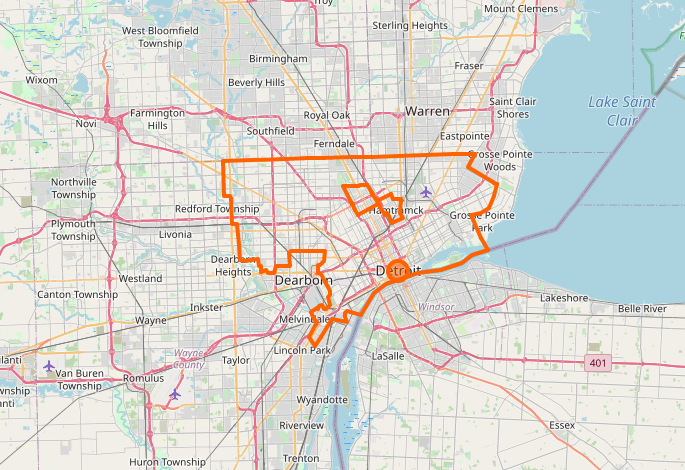


Goals:

- Assess the quality of the data for validity, accuracy, completeness, consistency and uniformity.
- Parse and gather data from popular file formats such as .csv, .json, .xml, and .html
- Process data from multiple files or very large files that can be cleaned programmatically.
- Store, query, and aggregate data using SQL.

First I looked at XML elements (nodes,way points, relation) information I found here: https://wiki.openstreetmap.org/wiki/OSM_XML

# Node
Nodes are individual dots used to mark specific locations. See example below:

# Way point 
Ways are used to create roads, paths, rivers, etc. See example below:

# Relation 
Relations are used to create map features, such as cycling routes, turn restrictions and areas that are not contiguous. See example below:

Looking through my OSM File I see some outstanding issues
# Problems:

- Assess the quality of the data for validity, accuracy, completeness, consistency and uniformity.

**Data Exploration**

In [167]:
import os
os.getcwd()

'C:\\Wrangle OpenStreetMap Data'

In [168]:
os.chdir("C:\Wrangle OpenStreetMap Data")
os.getcwd()

'C:\\Wrangle OpenStreetMap Data'

In [169]:
#Importing modules
import xml.etree.ElementTree as ET
from collections import defaultdict
import re
import pprint
import csv
import codecs

**Get SAMPLE FILE** 

In [173]:
#Import osm file and create sample dataset

#!/usr/bin/env python
# -*- coding: utf-8 -*-

OSM_FILE = "detroit_map.osm"
OSMFILE = "sample.osm"

k = 10 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

            
with open(OSMFILE, 'w', encoding='utf8') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')
    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='unicode'))
    output.write('</osm>')


**Count the unique element types.**

In [174]:
def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename, events=('start', )):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

def test():

    tags = count_tags('sample.osm')
    pprint.pprint(tags)
    

if __name__ == "__main__":
    test()

{'member': 18040,
 'nd': 448870,
 'node': 364200,
 'osm': 1,
 'relation': 810,
 'tag': 173071,
 'way': 63842}


**Getting the "k" value and  a count** of each of the tag categories in a dictionary.

In [175]:
lower = re.compile(r'^([0-9a-z]|_)*$') #valid tags that contain only lowercase letters 
lower_colon = re.compile(r'^([a-z]|_)*:([0-9a-z]|_|-)*$') #valid lowercase letter tags with a colon in their names
upper = re.compile(r'^([A-Z]|_)*$') #valid tags that contain only uppercase letters
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]') #tags with problematic characters


def key_type(element, keys):
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys['lower'] += 1
            # print('lower: ' + element.attrib['k'])
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon'] += 1
            # print('lower_col: ' + element.attrib['k'])
        elif upper.search(element.attrib['k']):
            keys['upper'] += 1
            # print('upper: ' + element.attrib['k'])
        elif problemchars.search(element.attrib['k']):
            keys['problemchars'] += 1
            # print('prob: ' + element.attrib['k'])
        else:
            # print('other--  ' + element.attrib['k'])
            keys['other'] += 1
    return keys



def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "upper":0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys


if __name__ == "__main__":
    pm = process_map('sample.osm')
    pprint.pprint(pm)

{'lower': 122403,
 'lower_colon': 48495,
 'other': 2020,
 'problemchars': 0,
 'upper': 153}


**Unique Users**

In [176]:
def get_user(element):
    return


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        try:
            users.add(element.attrib['uid'])
        except KeyError:
            continue

    return users


def test():

    users = process_map('sample.osm')
    pprint.pprint(len(users))

if __name__ == "__main__":
    test()


1550


**Checking the validity and consistency**

Lets take a look at the street names and do some cleaning 

In [177]:
OSMFILE = "sample.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Road", "Street", "Drive", "Highway", "Lane", "Avenue","Boulevard", "Circle", "Court", "Crescent", "Grove",
             "Place"]

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def print_sorted_dic(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print("%s: %d" % (k, v))

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit():
#    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    pprint.pprint(dict(street_types))

if __name__ == '__main__':
    audit()

{'10': {'Concession Road 10', 'Sideroad 9 & 10'},
 '11': {'Concession Road 11'},
 '12': {'Concession Road 12'},
 '14': {'Sideroad 13 & 14'},
 '17': {'Sideroad 16 & 17'},
 '22': {'County Road 22'},
 '3': {'Concession Road 3', 'Kings Highway 3'},
 '34': {'County Road 34'},
 '4': {'Concession Road 4'},
 '42': {'County Road 42'},
 '46': {'County Road 46'},
 '6': {'Concession Road 6'},
 '7': {'Concession Road 7'},
 '8': {'Concession Road 8'},
 '9': {'Concession Road 9'},
 'Affeldt': {'Affeldt'},
 'Ave': {'Gratiot Ave', 'Michigan Ave', 'Grand River Ave'},
 'Ave.': {'Jefferson Ave.'},
 'Belmont': {'Belmont'},
 'Blvd': {'Lacasse Blvd', 'East Boston Blvd', 'West Boston Blvd'},
 'Blvd.': {'Little River Blvd.'},
 'Canterbury': {'Canterbury'},
 'Cove': {'Glen Cove'},
 'Dequindre': {'Dequindre'},
 'Detroit': {'Mt Elliott St, Detroit'},
 'Dr.': {'Westchester Dr.'},
 'East': {'Cabana Road East',
          'Chatham Street East',
          'Grand Marais Road East',
          'Kennedy Drive East',
     

In [178]:
OSMFILE = "sample.osm"

mapping = {    "Rd" : "Road",
               "Rd." : "Road",
               "road" : "Road",
               "street": "Street",
               "Dr." : "Drive",
               "Hwy" : "Highway",
               "Ln" : "Lane",
               "Ave" : "Avenue",
               "Blvd" : "Boulevard",
               "Blvd." : "Boulevard"
            }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osmfile, events=("start",)):

        if elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types


def update_name(name, mapping):
    for key, value in mapping.items():
        if re.search(key, name):
            name = re.sub(street_type_re, value, name)

    return name


def test():
    st_types = audit(OSMFILE)
    for st_type, ways in st_types.items():
        for name in ways:
            better_name = update_name(name, mapping)
            print (name, "=>", better_name)


if __name__ == '__main__':
    test()

Evergreen Rd => Evergreen Road
E 11 Mile Rd => E 11 Mile Road
Plymouth Rd => Plymouth Road
Mt Elliott St, Detroit => Mt Elliott St, Detroit
W McNichols => W McNichols
West McNichols => West McNichols
West State Fair => West State Fair
Davison Street West => Davison Street West
Bethune Street West => Bethune Street West
Adams Street West => Adams Street West
Tecumseh Road West => Tecumseh Road West
Jefferson Avenue West => Jefferson Avenue Avenue
Fort Street West => Fort Street West
Cadillac Square => Cadillac Square
West Congress St => West Congress St
Jefferson Ave. => Jefferson Avenue
Westchester Dr. => Westchester Drive
St. Rose => St. Rose
Little River Blvd. => Little River Boulevard
Tecumseh Road East => Tecumseh Road East
Rvierside Drive East => Rvierside Drive Drive
Grand Marais Road East => Grand Marais Road East
Wyandotte Street East => Wyandotte Street East
Lantz Street East => Lantz Street East
Riverside Drive East => Riverside Drive Drive
Chatham Street East => Chatham Stre

No problems here

**Checking zip codes**

In [179]:
# Here we create a dictionary of our postal codes
def audit_postal_code(postal_code_types, postal_code):  
    if not postal_code.isupper() or ' ' not in postal_code:
        postal_code_types['Postal Codes'].add(postal_code)
    else:
        postal_code_types['other'].add(postal_code)
    return postal_code_types

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit(filename):
    f = (filename)
    postal_code_types = defaultdict(set)
    
    for event, element in ET.iterparse(f, events=("start",)):
        if element.tag =="way":
            for tag in element.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(postal_code_types, tag.attrib['v'])
    print(dict(postal_code_types))

if __name__ == '__main__':
    audit(OSMFILE)

{'other': {'N9A 1X9', 'N8Y 1L4', 'N9A 1T1', 'N9A 4N2', 'N8N 3P3', 'N9J 2A5', 'N8N 2C1', 'N9G 3G1', 'N8N 1A6', 'N9G 3E6', 'N9G 3G5', 'N8N 1A7', 'N9G 3E5', 'N8S 1X4', 'N9C 2J9', 'N8S 1E6', 'N8S 1B6', 'N8T 1C5', 'N8Y 1R7', 'N8P 1L7', 'N9A 4N1', 'N9C 4G8', 'N9A 2X2', 'N8S 4V2', 'N8N 1A8', 'N9B 3P4', 'N9C 1C3', 'N9B 0B9', 'N8X 2T2', 'N8X 1P1', 'N8X 4K2', 'N9A 6Z3', 'N8S 1N3', 'N8P 2A3', 'N9A 3B3', 'N8P 1A1', 'N9A 5A4', 'N9B 2Z8', 'N8N 1A4', 'N9A 1H6', 'N9A 5S8', 'N8R 1E9', 'N9B 0B6', 'N8T 1S1', 'N9G 1V9', 'N8X 1H4', 'N8S 3N1', 'N9A 6N5', 'N9A 1S8', 'N8W 1Y6', 'N8N 1A9', 'N9G 3E7', 'N8N 1A3', 'N8T 2H9', 'N8S 1W4'}, 'Postal Codes': {'48184', '48238', '48221', '48214', '48236', '48230', '2651', '48124', '48015', '48220', '48076', '48066', '48205', '48071', '48206', '48235-2356', '48334', '48209', '48375', '48229', '48030', '48075', '48067', '48335', '48237', '48234', '48091', '48152', '48126', '48185', '48239', '48201', '48200', '48212', '48167', '48213', '48150', '48215', '48226', '48217', '4

In [180]:
OSMFILE = "sample.osm"
postal_code_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["48184", "48238", "48221", "48214", "48236", "48230", "2651", "48124",
            "48015", "48220", "48076", "48066", "48205", "48071", "48206", "48235-2356", 
            "48334", "48209", "48375", "48229", "48030", "48075", "48067", "48335", "48237",
            "48234", "48091", "48152", "48126", "48185", "48239", "48201", "48200", "48212",
            "48167", "48213", "48150", "48215", "48226", "48217", "48127", "48141", "48240",
            "48204", "48207", "48216", "48180", "48086", "48219", "48034", "48195", "48192",
            "48224", "48233-9998", "48223", "48203", "48228", "48235", "48090", "48174", "48089",
            "48377", "48070", "48146", "48211", "48101", "48122", "48210", "48227", "48120", "48072",
            "48208", "48336", "48168", "48125", "48021", "48202"]


def audit_postal_code(postal_code_types, postal_codes):
    m = postal_code_type_re.search(postal_codes)
    if m:
        postal_code = m.group()
        if postal_code not in expected:
            postal_code_types[postal_code].add(postal_code)

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")


def audit():
    postal_codes = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(postal_codes, tag.attrib['v'])
    
    print("Postal codes in data set that are not in Detroit")
    pprint.pprint(dict(postal_codes))

if __name__ == '__main__':
    audit()

Postal codes in data set that are not in Detroit
{'0B6': {'0B6'},
 '0B9': {'0B9'},
 '1A1': {'1A1'},
 '1A2': {'1A2'},
 '1A3': {'1A3'},
 '1A4': {'1A4'},
 '1A6': {'1A6'},
 '1A7': {'1A7'},
 '1A8': {'1A8'},
 '1A9': {'1A9'},
 '1B6': {'1B6'},
 '1C3': {'1C3'},
 '1C5': {'1C5'},
 '1E6': {'1E6'},
 '1E9': {'1E9'},
 '1H4': {'1H4'},
 '1H6': {'1H6'},
 '1L4': {'1L4'},
 '1L7': {'1L7'},
 '1N3': {'1N3'},
 '1P1': {'1P1'},
 '1R7': {'1R7'},
 '1S1': {'1S1'},
 '1S4': {'1S4'},
 '1S8': {'1S8'},
 '1T1': {'1T1'},
 '1V9': {'1V9'},
 '1W4': {'1W4'},
 '1X4': {'1X4'},
 '1X7': {'1X7'},
 '1X9': {'1X9'},
 '1Y6': {'1Y6'},
 '2A3': {'2A3'},
 '2A5': {'2A5'},
 '2C1': {'2C1'},
 '2H9': {'2H9'},
 '2J9': {'2J9'},
 '2L9': {'2L9'},
 '2M1': {'2M1'},
 '2M9': {'2M9'},
 '2T2': {'2T2'},
 '2X2': {'2X2'},
 '2Z8': {'2Z8'},
 '3B3': {'3B3'},
 '3E5': {'3E5'},
 '3E6': {'3E6'},
 '3E7': {'3E7'},
 '3G1': {'3G1'},
 '3G5': {'3G5'},
 '3N1': {'3N1'},
 '3P3': {'3P3'},
 '3P4': {'3P4'},
 '3P5': {'3P5'},
 '3S1': {'3S1'},
 '48073': {'48073'},
 '48080': {'

**Unique Keys**

In [181]:
def unique_keys(filename):
    distinct_keys=[]
    count=1

    EL=get_element(filename, tags=('node', 'way', 'relation'))
    for element in EL:
        if element.tag=='node' or element.tag=='way':
            for tag in element.iter('tag'):
                if tag.attrib['k'] not in distinct_keys:
                    distinct_keys.append(tag.attrib['k'])
                    count+=1
    distinct_keys.sort()
    print("Total number of unique keys (tag attrib['k'])is {}:".format(count))
    
#    return distinct_keys
    pprint.pprint(distinct_keys)
    
unique_keys(OSMFILE)  

Total number of unique keys (tag attrib['k'])is 563:
['NHD:ComID',
 'NHD:FCode',
 'NHD:FDate',
 'NHD:FTYPE',
 'NHD:FType',
 'NHD:GNIS_ID',
 'NHD:RESOLUTION',
 'NHD:ReachCode',
 'NHD:way_id',
 'NHS',
 'abandoned',
 'abandoned:amenity',
 'abandoned:building',
 'access',
 'addr:city',
 'addr:city:simc',
 'addr:country',
 'addr:housename',
 'addr:housenumber',
 'addr:interpolation',
 'addr:postcode',
 'addr:province',
 'addr:state',
 'addr:street',
 'addr:unit',
 'admin_level',
 'advertising',
 'aeroway',
 'alt_name',
 'amenity',
 'amenity_1',
 'animal_keeping',
 'animal_keeping:type',
 'architect',
 'area',
 'area:highway',
 'artist_name',
 'artwork_type',
 'atm',
 'attribution',
 'automatic_door',
 'backrest',
 'barrier',
 'barrier:rfid',
 'beauty',
 'beds',
 'bench',
 'bicycle',
 'bicycle_parking',
 'bin',
 'board_type',
 'boat',
 'bollard',
 'border_type',
 'boundary',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'bridge',
 'bridge:structure',
 'bridge:support',
 'building',
 'bui

**Auditing the street names**

In [183]:
# run in Python 3

OSMFILE = "sample.osm"

street_type_re = re.compile('pattern, re.VERBOSE')


# I- count occurences for each street type
def count_street_type(street_type_count, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_type_count[street_type] +=1
    else:
        street_type_count[street_name] +=1


# II- group streets by type
def group_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_types[street_type].add(street_name)
    else:
        street_types[street_name].add(street_name)

# sorts the count of street types in descending order
def sort_values(street_type_count):
    sorted_counts = []
    d_view = [(v,k) for k,v in street_type_count.items()]
    d_view.sort(reverse=True) # natively sort tuples by first element
    for v,k in d_view:
        sorted_counts.append("%s: %d" % (k,v))
    return sorted_counts


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

# perform all of the above audits on the file
def audit(osmfile):
    osm_file = open(osmfile, "r")

    street_type_count = defaultdict(int)
    street_types = defaultdict(set)
    
    for event, elem in ET.iterparse(osmfile, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    count_street_type(street_type_count, tag.attrib['v'])
                    group_street_type(street_types, tag.attrib['v'])
                
    osm_file.close()

    street_type_count = sort_values(street_type_count)

    return street_type_count, street_types


pprint.pprint(audit(OSMFILE))

(['Tecumseh Road East: 30',
  'Woodward Avenue: 29',
  'Wyandotte Street East: 27',
  'Riverside Drive East: 27',
  'Spring Lane: 23',
  'Michigan Avenue: 23',
  'Lakeview Boulevard: 22',
  'Fort Street: 17',
  'West 9 Mile Road: 16',
  'Webb Street: 16',
  'Lauzon Road: 16',
  'Burlingame Street: 16',
  'Walker Road: 15',
  'Trowbridge Street: 15',
  'Malden Road: 15',
  'Gratiot Avenue: 15',
  'Collingwood Street: 15',
  'Calvert Street: 15',
  'North Talbot Road: 14',
  'Lawrence Street: 14',
  'Grand River Avenue: 14',
  'County Road 42: 14',
  'Southfield Road: 13',
  'Rvierside Drive East: 13',
  'Little River Road: 13',
  'Edwin Street: 13',
  'East Jefferson Avenue: 13',
  'Carlisle Street: 13',
  'Woodstock Drive: 12',
  'Northline Road: 12',
  'Lesperance Road: 12',
  'Lasalle Boulevard: 12',
  'Kingston Avenue: 12',
  'Biddle Avenue: 12',
  'Tecumseh Road: 11',
  'Talbot Avenue: 11',
  'Pillette Road: 11',
  'Manning Road: 11',
  'Front Road: 11',
  'College Avenue: 11',
  '

Checking on **state names**

In [184]:
def is_state(elem):
    return (elem.attrib['k'] == "addr:state")

state_types = defaultdict(int)

def audit_state(state_types, state_name):
    if state_name != 'MI':
        state_types[state_name] += 1
        print(state_name)

for event, elem in ET.iterparse(OSMFILE, events =("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_state(tag):
                audit_state(state_types, tag.attrib['v'])       

My state names are clean

And lastly **phone numbers**

In [185]:
def is_phone(elem):
    return (elem.attrib['k'] == "phone" or elem.attrib['k'] == "contact:phone")

def audit_phone_number_formats(phone_number_formats, phone_number):

    # Convert any digit to an 'X' sign (e.g. '(212) 333-3100' becomes '(XXX) XXX-XXXX')
    phone_number_format = re.sub('\d', 'X', phone_number)
    phone_number_formats[phone_number_format] += 1

def audit(osmfile):
    osmfile = OSMFILE
    phone_number_formats = defaultdict(int)
    for event, elem in ET.iterparse(osmfile, events=('start',)):

        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                # Audit phone numbers
                if is_phone(tag):
                    audit_phone_number_formats(phone_number_formats, tag.attrib['v'])
    pprint.pprint(dict(phone_number_formats))

audit(OSMFILE)

{'+X XXX XXX XXXX': 17,
 '+X XXX XXX-XXXX': 4,
 '+X XXX XXXXXXX': 1,
 '+X XXX-XXX-XXXX': 3,
 '+X-XXX-XXX-XXXX': 85,
 '+XXXXXXXXXXX': 1,
 'XXX-XXX-XXXX': 1}


One last cleap up of the dataset

In [186]:
OSMFILE = "sample.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Road", "Street", "Drive", "Highway", "Lane", "Avenue","Boulevard", "Circle", "Court", "Crescent", "Grove",
             "Place"]

mapping = {    "Rd" : "Road",
               "Rd." : "Road",
               "road" : "Road",
               "street": "Street",
               "Dr." : "Drive",
               "Hwy" : "Highway",
               "Ln" : "Lane",
               "Ave" : "Avenue",
               "Blvd" : "Boulevard",
               "Blvd." : "Boulevard"
            }

def fix_street(elem):

    street_types = defaultdict(set)
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_street_name(tag):
                audit_street_type(street_types, tag.attrib['v'])

            for st_type, ways in street_types.items():
                for name in ways:
                    for key,value in mapping.items():
                        n = street_type_re.search(name)
                        if n:
                            street_type = n.group()
                            if street_type not in expected:
                                if street_type in mapping:
                                    better_name = name.replace(key,value)
                                    if better_name != name:
                                        print ("Fixed Street:", tag.attrib['v'], "=>", better_name)
                                        tag.attrib['v'] = better_name
                                        return

                                
fix_street(elem)

In [187]:
def fix_state(elem):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_state(tag):
                    if tag.attrib['v'] != 'MI':
                        print ("Fixed State: ", tag.attrib['v'], "=> 'MI'")
                        tag.attrib['v'] = 'MI'

# Data Reshaping and Exporting to CSV Files

In [188]:
# schema.py

schema = {
    'node': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}

**Preparing the data to be inserted into a SQL database**

In [189]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET

import cerberus

import schema

OSM_PATH = "sample.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

print ("Street Names and State Codes Fixed:")
print ("\n")

# Fix Street & State Names                             
def fix_element(elem):
    fix_street(elem)
    fix_state(elem)
                                

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    # Fix data issues, based on auditing results

    fix_element(element)

    # Shape elements, by splitting the attribute fields per the rules described in the
    # Udacity commentary

    if element.tag == 'node':

            for node_field in node_attr_fields:
                node_attribs[node_field] =element.attrib[node_field]

            for tag in element.iter('tag'):
                k = tag.attrib['k']

                # ignores tags containing problem characters in the k tag attribute:

                if re.search(PROBLEMCHARS,k):
                    continue
                else:
                    pass

                tag_dict = {}

                tag_dict['id'] = node_attribs['id']

                colon_find = re.split('[:]', k)

                if len(colon_find) == 1:

                    tag_dict['key'] = k
                    tag_dict['type'] = 'regular'

                elif len(colon_find) == 2:

                    tag_dict['key'] = colon_find[1]
                    tag_dict['type'] = colon_find[0]

                elif len(colon_find) > 2:

                    tag_dict['key'] = ':'.join(colon_find[1:])
                    tag_dict['type'] = colon_find[0]

                tag_dict['value'] = tag.attrib['v']

                tags.append(tag_dict)

            return {'node': node_attribs, 'node_tags': tags}

    elif element.tag == 'way':

        for way_field in way_attr_fields:
            way_attribs[way_field] =element.attrib[way_field]

        for tag in element.iter('tag'):
            k = tag.attrib['k']

            # ignores tags containing problem characters in the k tag attribute:

            if re.search(PROBLEMCHARS,k):
                print ("Problem character found - skipping element")
                continue
            else:
                pass

            tag_dict = {}

            tag_dict['id'] = way_attribs['id']

            colon_find = re.split('[:]', k)

            if len(colon_find) == 1:

                tag_dict['key'] = k
                tag_dict['type'] = 'regular'

            elif len(colon_find) == 2:

                tag_dict['key'] = colon_find[1]
                tag_dict['type'] = colon_find[0]

            elif len(colon_find) > 2:

                tag_dict['key'] = ':'.join(colon_find[1:])
                tag_dict['type'] = colon_find[0]

            tag_dict['value'] = tag.attrib['v']

            tags.append(tag_dict)

        n = 0
        for nd in element.iter('nd'):

            nd_dict = {}

            nd_dict['id'] = way_attribs['id']
            nd_dict['node_id'] = nd.attrib['ref']
            nd_dict['position'] = n
            way_nodes.append(nd_dict)
            n+=1

        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


        
# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=schema):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.items())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: v for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w', 'utf-8') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w', 'utf-8') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w', 'utf-8') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w', 'utf-8') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w', 'utf-8') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=False)
    
print("Reshaping and export complete.")

Street Names and State Codes Fixed:


Fixed Street: E 9 Mile Rd => E 9 Mile Road
Fixed Street: Gratiot Ave => Gratiot Avenue
Fixed Street: Grand River Ave => Grand River Avenue
Fixed Street: E McNichols Rd => E McNichols Road
Fixed Street: W. 7 Mile Rd. => W. 7 Mile Road.
Fixed Street: E 11 Mile Rd => E 11 Mile Road
Fixed Street: Westchester Dr. => Westchester Drive
Fixed Street: Westchester Dr. => Westchester Drive
Fixed Street: Little River Blvd. => Little River Boulevard.
Fixed Street: Little River Blvd. => Little River Boulevard.
Fixed Street: Evergreen Rd => Evergreen Road
Fixed Street: East Boston Blvd => East Boston Boulevard
Fixed Street: Plymouth Rd => Plymouth Road
Fixed Street: Lacasse Blvd => Lacasse Boulevard
Fixed Street: East Boston Blvd => East Boston Boulevard
Fixed Street: West Boston Blvd => West Boston Boulevard
Fixed Street: Michigan Ave => Michigan Avenue
Reshaping and export complete.


# Data Import

After thoroughly auditing and cleaning my dataset, I converted it from XML to CSV format. Now I am ready to import the cleaned .csv files into my new  Database ("data_wrangling_schema.db") using the Udacity provided schema

In [190]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('data_wrangling_schema.db')
cursor = conn.cursor()
print("Opened database successfully")


Opened database successfully


**Creating the tables** (using the schema below in used sqlite)

**Importing data** into the tables (using the script below in used sqlite)


In [191]:
cursor.execute("ANALYZE;")
cursor.execute("SELECT tbl, stat FROM sqlite_stat1;")
rows = cursor.fetchall()
db_stats = pd.DataFrame(rows[::-1], columns=['Table','Number'])
db_stats

,Table,Number


# Number of nodes

In [192]:
SELECT COUNT(*) FROM nodes;

SyntaxError: invalid syntax (<ipython-input-192-d6111daea2bf>, line 1)

# Number of ways

In [193]:
SELECT COUNT(*) FROM ways;

SyntaxError: invalid syntax (<ipython-input-193-297397a2a9ec>, line 1)

# Number of unique users

In [194]:
SELECT COUNT(DISTINCT(e.uid))          
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;

SyntaxError: invalid syntax (<ipython-input-194-aa990164abf2>, line 1)

# Top 10 contributing users

In [195]:
SELECT e.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
GROUP BY e.user
ORDER BY num DESC
LIMIT 10;

SyntaxError: invalid syntax (<ipython-input-195-6a194ecb7c91>, line 1)

# Number of users appearing only once

In [196]:
SELECT COUNT(*) 
FROM
    (SELECT e.user, COUNT(*) as num
     FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
     GROUP BY e.user
     HAVING num=1)  u;

SyntaxError: invalid syntax (<ipython-input-196-dc47de1e5bbf>, line 1)

# Top 10 appearing amenities

In [197]:
SELECT value, COUNT(*) as num
FROM nodes_tags
WHERE key='amenity'
GROUP BY value
ORDER BY num DESC
LIMIT 10;

SyntaxError: invalid syntax (<ipython-input-197-7f06152c36e7>, line 1)

# Biggest religion 

In [198]:
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='place_of_worship') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='religion'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 1;

SyntaxError: invalid syntax (<ipython-input-198-6e7f9c325ee6>, line 1)

# Most popular cuisines

In [199]:
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC;

SyntaxError: invalid syntax (<ipython-input-199-ed0bab1e869e>, line 1)

# Sort cities by count, descending

In [220]:
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) tags
WHERE tags.key LIKE '%city'
GROUP BY tags.value
ORDER BY count DESC
LIMIT 10;

SyntaxError: invalid syntax (<ipython-input-220-791b1876efb5>, line 1)

# Postal Codes

In [221]:
SELECT tags.value, COUNT(*) as count
FROM (SELECT * FROM nodes_tags
     UNION ALL
          SELECT * FROM ways_tags) tags
WHERE tags.key='postcode'
GROUP BY tags.value
ORDER BY count DESC
LIMIT 10;

SyntaxError: invalid syntax (<ipython-input-221-6d09ec2fb012>, line 1)

In [222]:
#Create a basic overview of the database stats.

cursor.execute("ANALYZE;")
cursor.execute("SELECT tbl, stat FROM sqlite_stat1;")
rows = cursor.fetchall()
db_stats = pd.DataFrame(rows[::-1], columns=['Table','Number'])
db_stats

,Table,Number


In [223]:
cursor.execute("select * from nodes_tags limit 5;")

OperationalError: no such table: nodes_tags